In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)

import imageio

import functions as func


### STUDY EVENT

select a particular file, look at the events in all fashions allowed by the file

**Important note: Event IDs are separated between MC and reco by reco_id = MC_id x 2**

#### MC

Contains 6 tables:

In [2]:
!ptdump example_files/sophronia_27_208Tl.h5:/MC/

/MC/ (Group) ''
/MC//configuration (Table(30,)shuffle, zlib(4)) ''
/MC//event_mapping (Table(316,)shuffle, zlib(4)) ''
/MC//hits (Table(116760,)shuffle, zlib(4)) ''
/MC//particles (Table(26089,)shuffle, zlib(4)) ''
/MC//sns_positions (Table(0,)shuffle, zlib(4)) ''
/MC//sns_response (Table(0,)shuffle, zlib(4)) ''


I dont really care about sns stuff, configuration is interesting, but really we care about hits and particles

In [3]:
evt_interest = np.load('/home/e78368jw/Downloads/tmp_out/testing_arena/signal_ids.npy', allow_pickle=True)

In [4]:
FILE_NUMBER = 27
# provide file_path here
#file_path = 'example_files/sophronia_27_208Tl.h5'
file_path = '/home/e78368jw/Downloads/tmp_out/testing_arena/rel_0.2/isaura_' + str(FILE_NUMBER) + '_208Tl.h5'

# read in
df = pd.read_hdf(file_path, 'MC/particles')
events = np.unique(df.event_id.to_numpy())

print("{} events\nRange: {} - {}\nMC events are even and odd, unlike other events.".format(len(events), np.min(events), np.max(events)))

# To demonstrate if events are in our range
'''
# currently above
evt_interest = np.array([ 500212, 360410,  880326,  880632,  140498, 1400312,  780070, 1300678, 1420010,
 1560046, 3400254, 3460222, 3460368, 4640148, 2380072, 2400166, 2400352, 2420264,
 2420484, 2020596, 5100182, 2720126, 2460486, 4900236, 4900564, 2200130, 2920164,
 2220538, 3320592, 3360136, 3040542, 5080500, 5080582, 3240618, 4340258, 4660390,
 4780540, 5240042, 5240092, 5280344, 5280466, 5380300, 5520326, 5560540, 5600600,
 5640604, 5860010, 5860356, 5960124, 5980316,  300152,  520014,  120106,  860132,
  440576,  160018, 1360020,  580310, 1000074, 1880268, 1820390, 1980402, 1580424,
 1440166, 1600396, 1720598, 4180102, 4180346, 2260440, 2260602, 2660104, 3340078,
 3340220, 3340240, 3340322, 4460044, 4460280, 3100132, 3100620, 3700418, 3180024,
 2980156, 3160430, 3560008, 3960556, 3580280, 3580598, 4160120, 4160460, 4100438,
 4260578, 4520630, 4820472, 4720252, 5160298, 5500348, 5700592, 5800362, 5800476,
 5920294])'''




print(f'events within this file from the above list: {np.intersect1d(evt_interest//2, events)}')



316 events
Range: 260000 - 260320
MC events are even and odd, unlike other events.
events within this file from the above list: [260016 260021 260024 260039 260047 260060 260061 260072 260082 260083
 260093 260099 260103 260123 260134 260135 260140 260141 260142 260145
 260147 260148 260151 260167]


**Select event**

In [88]:
evt = events[55]
print("Selected event: {} ({})".format(evt, evt*2))

Selected event: 260056 (520112)


**Load particle information**

Gives full information about particle interactions related to a Tl208 decay

In [12]:
# done already to determine number of events
print(df.columns.to_numpy())
df_ps = df[df.event_id == evt]
display(df_ps)

['event_id' 'particle_id' 'particle_name' 'primary' 'mother_id'
 'initial_x' 'initial_y' 'initial_z' 'initial_t' 'final_x' 'final_y'
 'final_z' 'final_t' 'initial_volume' 'final_volume' 'initial_momentum_x'
 'initial_momentum_y' 'initial_momentum_z' 'final_momentum_x'
 'final_momentum_y' 'final_momentum_z' 'kin_energy' 'length'
 'creator_proc' 'final_proc']


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
1410,1070017,1,Tl208,True,0,399.503754,395.205109,533.835632,0.000000,399.503754,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay
1411,1070017,4,e-,False,1,399.503754,395.205109,533.835632,0.000867,397.389313,...,-0.234891,-0.447929,-0.057152,0.00000,0.000000,0.000000,0.210251,4.212353e+00,RadioactiveDecay,eIoni
1412,1070017,3,anti_nu_e,False,1,399.503754,395.205109,533.835632,0.000867,-4370.776855,...,-0.390510,0.233863,0.979586,-0.39051,0.233863,0.979586,1.080175,1.319491e+04,RadioactiveDecay,Transportation
1413,1070017,2,Pb208[3708.451],False,1,399.503754,395.205109,533.835632,0.000867,399.503754,...,0.625400,0.214067,-0.922433,0.00000,0.000000,-0.000000,0.000003,0.000000e+00,RadioactiveDecay,RadioactiveDecay
1414,1070017,6,gamma,False,2,399.503754,395.205109,533.835632,0.000867,394.442810,...,0.007519,-0.585893,-0.923768,-0.00000,-0.000000,-0.000000,1.093926,7.009041e+02,RadioactiveDecay,phot
1415,1070017,32,e-,False,6,394.442810,67.673851,-37.163212,2.338831,394.442810,...,-0.000626,0.003615,0.006767,-0.00000,0.000000,0.000000,0.000058,1.447787e-07,phot,msc
1416,1070017,31,e-,False,6,394.442810,67.673851,-37.163212,2.338831,394.442810,...,-0.000527,0.006297,0.004429,-0.00000,0.000000,0.000000,0.000058,1.450558e-07,phot,msc
1417,1070017,30,e-,False,6,394.442810,67.673851,-37.163212,2.338831,394.442810,...,-0.012697,0.020078,0.019354,-0.00000,0.000000,0.000000,0.000918,1.686907e-05,phot,eIoni
1418,1070017,29,e-,False,6,394.442810,67.673851,-37.163212,2.338831,394.442810,...,0.004360,0.019180,0.020315,0.00000,0.000000,0.000000,0.000782,1.359353e-05,phot,eIoni
1419,1070017,28,e-,False,6,394.442810,67.673851,-37.163212,2.338831,394.442780,...,-0.071916,0.034017,0.030734,-0.00000,0.000000,-0.000000,0.007068,2.913093e-04,phot,eIoni


**Load hits**

,event_id,particle_id,hit_id,x,y,z,time,energy,label
6816,1070017,34,0,259.308411,338.415680,387.962402,0.701818,0.000058,ACTIVE
6817,1070017,39,0,259.308411,338.415680,387.962433,0.701820,0.000044,ACTIVE
6818,1070017,38,0,259.308380,338.415710,387.962463,0.701834,0.000047,ACTIVE
6819,1070017,37,0,259.308380,338.415680,387.962402,0.701833,0.000010,ACTIVE
6820,1070017,36,0,259.308411,338.415649,387.962463,0.701832,0.000049,ACTIVE
...,...,...,...,...,...,...,...,...,...
7744,1070017,52,12,199.371582,316.622681,400.381317,0.979754,0.001606,ACTIVE
7745,1070017,52,13,199.373566,316.630035,400.378510,0.979956,0.000857,ACTIVE
7746,1070017,52,14,199.379593,316.629395,400.379272,0.980124,0.000689,ACTIVE
7747,1070017,52,15,199.380707,316.626617,400.375763,0.980264,0.001062,ACTIVE


/tmp/ipykernel_43336/101769705.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


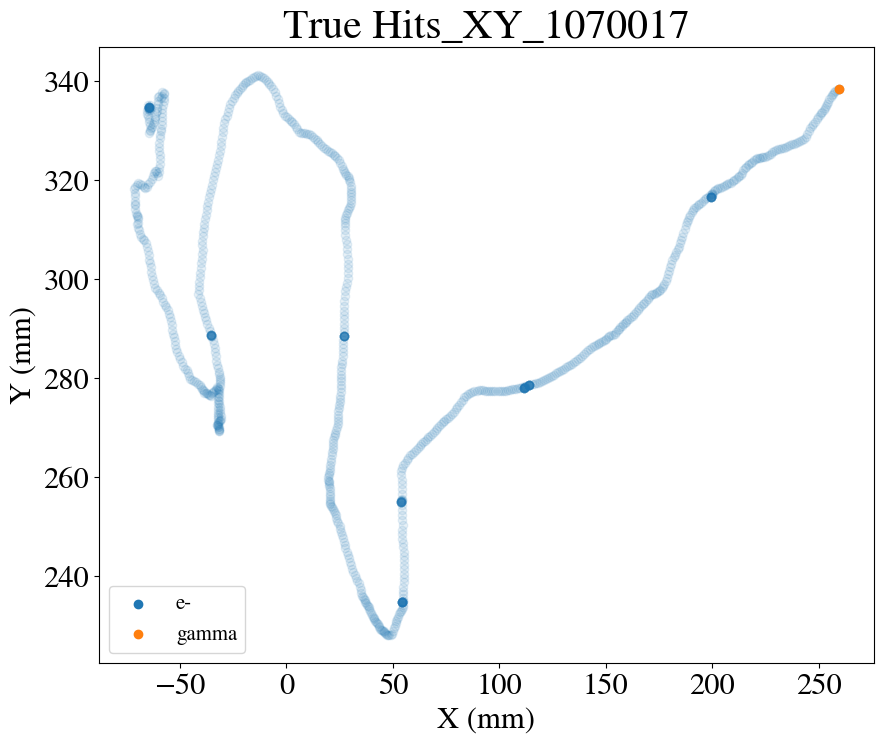

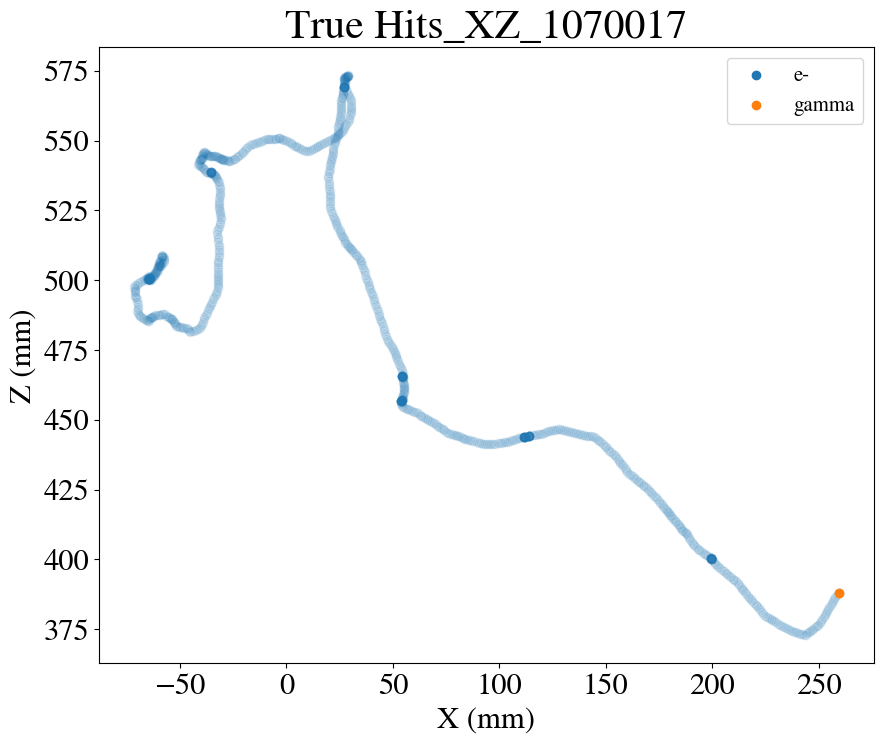

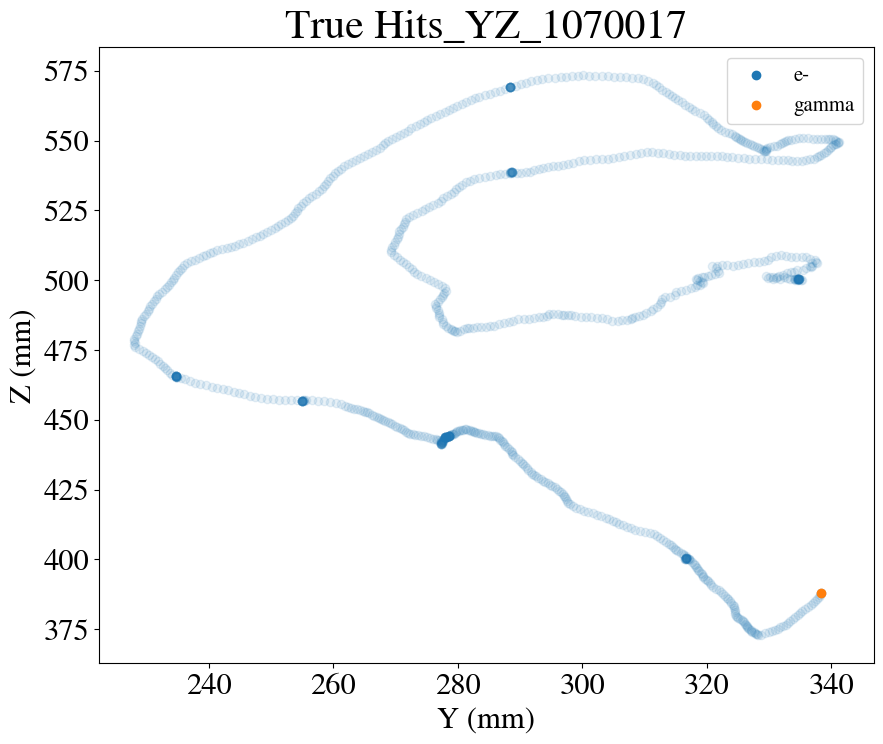

In [13]:
true_info = mcio.load_mchits_df(file_path).reset_index()

this_evt_true_info = true_info[true_info.event_id == evt]

display(this_evt_true_info)

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

######## PLOTTING

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")

this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

   
    if (pid == 'gamma') or (pid == 'Xe131') or (pid == 'Xe129'):
        plt.scatter(xt, yt,  alpha=1, label = str(pid))
    else:
        plt.scatter(xt, yt,  alpha=0.1, label = str(pid))

    
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');

# Retrieve legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a single legend for all subplots
legend = plt.legend(handles, labels, fontsize=15)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.title('True Hits_XY_' + str(evt), fontsize=30)
plt.show()


for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

   
    if (pid == 'gamma') or (pid == 'Xe131') or (pid == 'Xe129'):
        plt.scatter(xt, zt,  alpha=1, label = str(pid))
    else:
        plt.scatter(xt, zt,  alpha=0.1, label = str(pid))

    
plt.xlabel('X (mm)');
plt.ylabel('Z (mm)');

# Retrieve legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a single legend for all subplots
legend = plt.legend(handles, labels, fontsize=15)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.title('True Hits_XZ_' + str(evt), fontsize=30)
plt.show()

for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

   
    if (pid == 'gamma') or (pid == 'Xe131') or (pid == 'Xe129'):
        plt.scatter(yt, zt,  alpha=1, label = str(pid))
    else:
        plt.scatter(yt, zt,  alpha=0.1, label = str(pid))

    
plt.xlabel('Y (mm)');
plt.ylabel('Z (mm)');

# Retrieve legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a single legend for all subplots
legend = plt.legend(handles, labels, fontsize=15)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.title('True Hits_YZ_' + str(evt), fontsize=30)
plt.show()

#### SOPHRONIA

In [18]:
soph_file = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_' + str(FILE_NUMBER) + '_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh
display(soph_hdst)
print(soph_hdst.event.min(), soph_hdst.event.max())
print(evt*2)
soph_hits = soph_hdst[soph_hdst.event == evt*2]
display(soph_hits)


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2140000,2.140002e+12,0,-31.663614,394.507697,1,-38.875,412.075,0.0,0.0,564.899213,5.507246,672.916675,-1.0,0.002338,-1,-1.0
1,2140000,2.140002e+12,0,-31.663614,394.507697,1,-23.325,396.525,0.0,0.0,564.899213,11.884058,1452.083325,-1.0,0.004970,-1,-1.0
2,2140000,2.140002e+12,0,-31.663614,394.507697,1,-54.425,365.425,0.0,0.0,567.827597,4.753623,154.971712,-1.0,0.000526,-1,-1.0
3,2140000,2.140002e+12,0,-31.663614,394.507697,1,-38.875,349.875,0.0,0.0,567.827597,5.043478,164.421205,-1.0,0.000547,-1,-1.0
4,2140000,2.140002e+12,0,-31.663614,394.507697,1,-38.875,365.425,0.0,0.0,567.827597,4.753623,154.971712,-1.0,0.000526,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143373,2140606,2.140607e+12,1,384.775611,260.497900,1,380.975,256.575,0.0,0.0,645.826913,6.434783,295.125000,-1.0,0.001224,-1,-1.0
143374,2140606,2.140607e+12,1,384.775611,260.497900,1,380.975,272.125,0.0,0.0,645.826913,14.434782,662.037146,-1.0,0.003005,-1,-1.0
143375,2140606,2.140607e+12,1,384.775611,260.497900,1,396.525,241.025,0.0,0.0,645.826913,6.492754,297.783783,-1.0,0.001235,-1,-1.0
143376,2140606,2.140607e+12,1,384.775611,260.497900,1,396.525,256.575,0.0,0.0,645.826913,11.826087,542.391903,-1.0,0.002250,-1,-1.0


2140000 2140606
2140034


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
8472,2140034,2.140035e+12,0,36.702912,294.349045,1,241.025,318.775,0.0,0.0,370.665028,5.739130,448.593766,-1.0,0.001535,-1,-1.0
8473,2140034,2.140035e+12,0,36.702912,294.349045,1,256.575,334.325,0.0,0.0,370.665028,5.391304,421.406234,-1.0,0.001462,-1,-1.0
8474,2140034,2.140035e+12,0,36.702912,294.349045,1,225.475,318.775,0.0,0.0,373.486378,7.594203,303.360513,-1.0,0.001012,-1,-1.0
8475,2140034,2.140035e+12,0,36.702912,294.349045,1,225.475,334.325,0.0,0.0,373.486378,10.782609,430.725619,-1.0,0.001459,-1,-1.0
8476,2140034,2.140035e+12,0,36.702912,294.349045,1,225.475,349.875,0.0,0.0,373.486378,4.811594,192.205505,-1.0,0.000666,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2140034,2.140035e+12,0,36.702912,294.349045,1,38.875,272.125,0.0,0.0,577.589644,5.159420,220.075011,-1.0,0.000713,-1,-1.0
9842,2140034,2.140035e+12,0,36.702912,294.349045,1,38.875,287.675,0.0,0.0,577.589644,5.333333,227.493289,-1.0,0.000738,-1,-1.0
9843,2140034,2.140035e+12,0,36.702912,294.349045,1,38.875,303.225,0.0,0.0,577.589644,12.521739,534.114657,-1.0,0.001741,-1,-1.0
9844,2140034,2.140035e+12,0,36.702912,294.349045,1,38.875,318.775,0.0,0.0,577.589644,7.710145,328.876161,-1.0,0.001072,-1,-1.0


Time spent in cut_over_Q: 0.014395952224731445 s
Time spent in drop_isolated: 0.04097914695739746 s


Text(0.5, 0.98, 'Processed Sensors Signal_1070017')

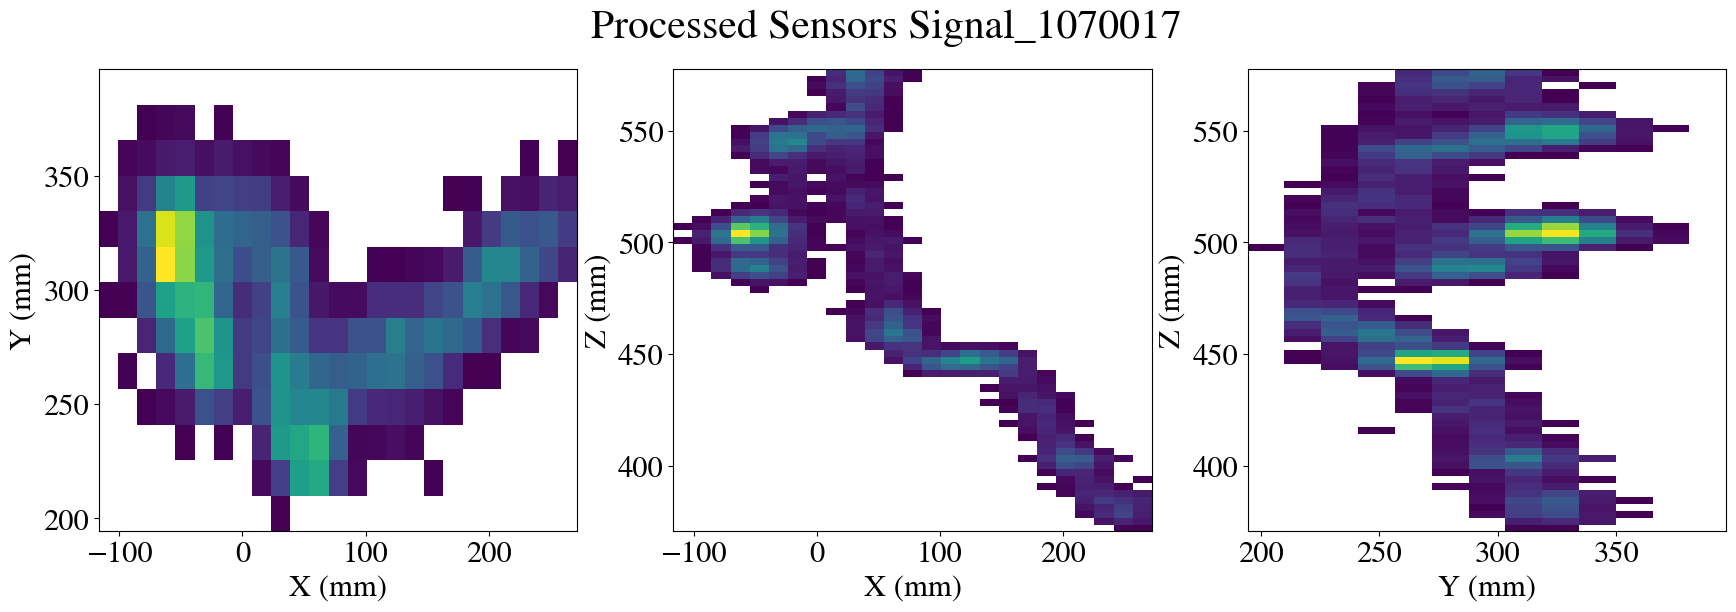

In [25]:
q_cut = 4
drop_dist       = [16, 16]
cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])
hits_cut = coref.timefunc(cut_sensors)(soph_hits.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
pitch = 15.55
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits_cut.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Processed Sensors Signal_' + str(evt), fontsize=30)

#plt.tight_layout()

### quick plotting change (for simplicity)

Text(0.5, 0.98, 'Post-sophronia sensor signal')

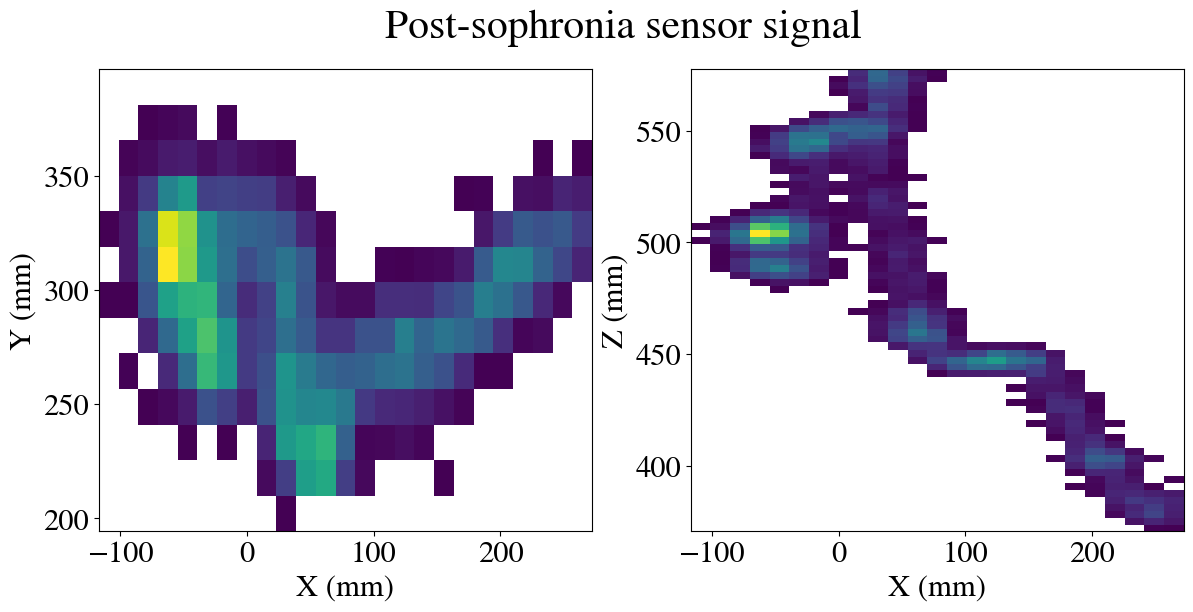

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits_cut.Z.unique()

xx_MC = xx
yy_MC = yy
zz_MC = zz

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


fig.suptitle('Post-sophronia sensor signal', fontsize=30)


#### BEERSHEBA

Pass through an isaura file

#### Track visualisation

In [83]:
file_path = '/home/e78368jw/Downloads/tmp_out/testing_arena/rel_0.2/isaura_' + str(FILE_NUMBER) + '_208Tl.h5'
#file_path = '/home/e78368jw/Downloads/tmp_out/testing_arena/isaura/isaura_' + str(FILE_NUMBER) + '_208Tl.h5'


hdst = dstio.load_dst(file_path, 'DECO', 'Events')#CHITS/lowTh

hits_deco = hdst[hdst.event == evt*2]
display(hits_deco)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
166481,2140034,2.140035e+12,0,36.702912,294.349045,0,241.875,319.575,0.0,0.0,370.665028,0.000007,0.000007,-1.0,0.000007,0,0.000007
166482,2140034,2.140035e+12,0,36.702912,294.349045,0,241.875,320.575,0.0,0.0,370.665028,0.000009,0.000009,-1.0,0.000009,0,0.000009
166483,2140034,2.140035e+12,0,36.702912,294.349045,0,241.875,321.575,0.0,0.0,370.665028,0.000009,0.000009,-1.0,0.000009,0,0.000009
166484,2140034,2.140035e+12,0,36.702912,294.349045,0,241.875,322.575,0.0,0.0,370.665028,0.000006,0.000006,-1.0,0.000006,0,0.000006
166485,2140034,2.140035e+12,0,36.702912,294.349045,0,242.875,319.575,0.0,0.0,370.665028,0.000010,0.000010,-1.0,0.000010,0,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194838,2140034,2.140035e+12,0,36.702912,294.349045,0,34.875,298.575,0.0,0.0,577.589644,0.000025,0.000025,-1.0,0.000025,0,0.000025
194839,2140034,2.140035e+12,0,36.702912,294.349045,0,34.875,299.575,0.0,0.0,577.589644,0.000023,0.000023,-1.0,0.000023,0,0.000023
194840,2140034,2.140035e+12,0,36.702912,294.349045,0,34.875,300.575,0.0,0.0,577.589644,0.000020,0.000020,-1.0,0.000020,0,0.000020
194841,2140034,2.140035e+12,0,36.702912,294.349045,0,35.875,294.575,0.0,0.0,577.589644,0.000018,0.000018,-1.0,0.000018,0,0.000018


Text(0.5, 0.98, 'deconvolved tracks after changes')

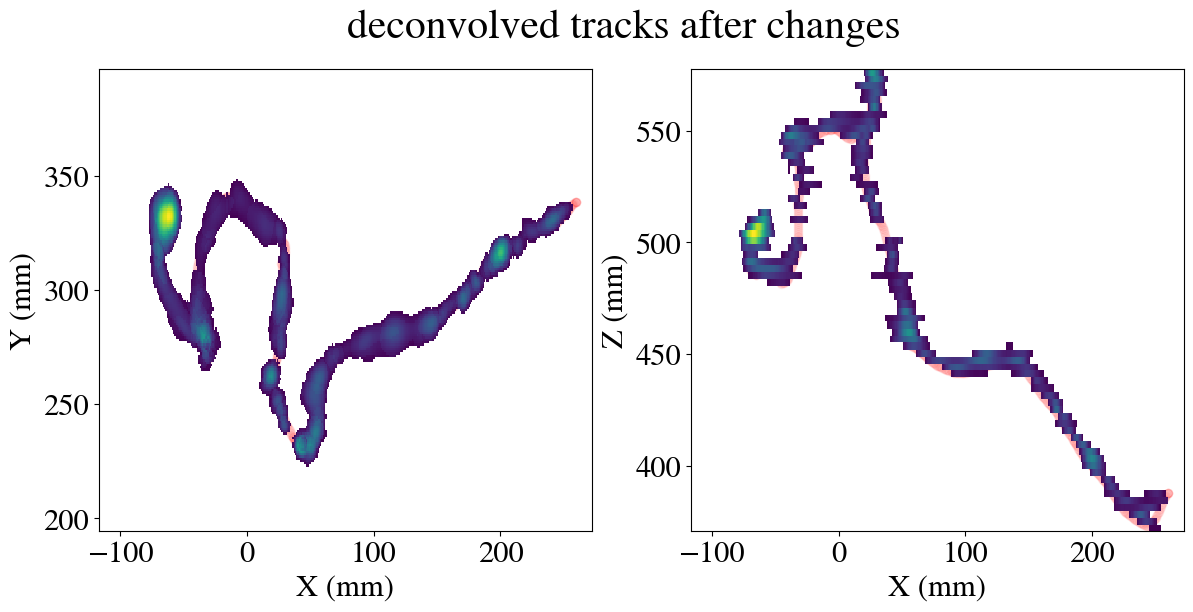

In [85]:
xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

xx = np.arange(hits_deco.X.min(), hits_deco.X.max())
yy = np.arange(hits_deco.Y.min(), hits_deco.Y.max())
zz = np.sort(hits_deco.Z.unique())

axes[0].scatter(xt, yt,  alpha=0.05, color='red')
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
axes[0].set_xlim([xx_MC.min(), xx_MC.max()])
axes[0].set_ylim([yy_MC.min(), yy_MC.max()])
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(xt, zt,  alpha=0.05, color='red')
axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);

axes[1].set_xlim([xx_MC.min(), xx_MC.max()])
axes[1].set_ylim([zz_MC.min(), zz_MC.max()])
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


fig.suptitle('deconvolved tracks after changes', fontsize=30)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
140171,2140034,2.140035e+12,0,36.702912,294.349045,0,-26.325,333.675,0.0,0.0,543.412406,0.000287,0.000287,-1.0,0.000287,-1,NaN
140172,2140034,2.140035e+12,0,36.702912,294.349045,0,-26.325,334.675,0.0,0.0,543.412406,0.000286,0.000286,-1.0,0.000286,-1,NaN
140173,2140034,2.140035e+12,0,36.702912,294.349045,0,-25.325,332.675,0.0,0.0,543.412406,0.000286,0.000286,-1.0,0.000286,-1,NaN
140174,2140034,2.140035e+12,0,36.702912,294.349045,0,-25.325,333.675,0.0,0.0,543.412406,0.000295,0.000295,-1.0,0.000295,-1,NaN
140175,2140034,2.140035e+12,0,36.702912,294.349045,0,-25.325,334.675,0.0,0.0,543.412406,0.000298,0.000298,-1.0,0.000298,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145755,2140034,2.140035e+12,0,36.702912,294.349045,0,-63.325,300.675,0.0,0.0,486.668503,0.000389,0.000389,-1.0,0.000389,1,0.000389
145756,2140034,2.140035e+12,0,36.702912,294.349045,0,-63.325,301.675,0.0,0.0,486.668503,0.000379,0.000379,-1.0,0.000379,1,0.000379
145757,2140034,2.140035e+12,0,36.702912,294.349045,0,-63.325,302.675,0.0,0.0,486.668503,0.000357,0.000357,-1.0,0.000357,1,0.000357
145758,2140034,2.140035e+12,0,36.702912,294.349045,0,-63.325,303.675,0.0,0.0,486.668503,0.000326,0.000326,-1.0,0.000326,1,0.000326


X maximum and minimum
249.675 -77.32499999999999

Y maximum and minimum
342.675 224.675

Z maximum and minimum
574.7100843750001 373.48637812500004


ValueError: `bins[1]` must be monotonically increasing, when an array

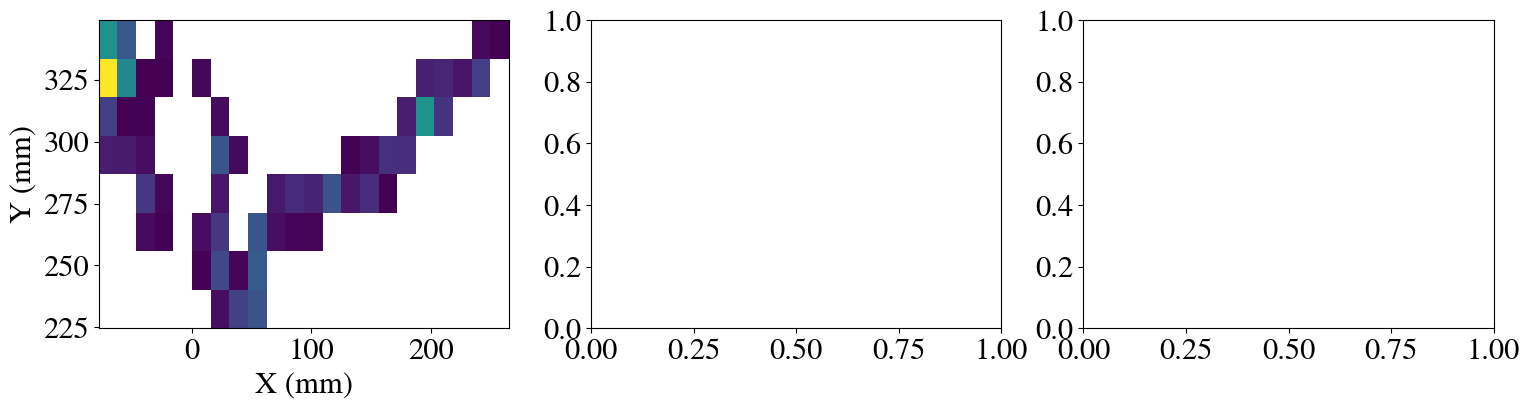

In [35]:
# relevant beersheba nonsense

pitch = 15.55


hdst = dstio.load_dst(file_path, 'DECO', 'Events')#CHITS/lowTh

hits = hdst[hdst.event == evt*2]
display(hits)

x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = func.collect_max_min(hits)
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

   
    if (pid == 'gamma') or (pid == 'Xe131') or (pid == 'Xe129'):
        axes[0].scatter(xt, yt,  alpha=1, label = str(pid))
        axes[1].scatter(xt, zt,  alpha=1, label = str(pid))
        axes[2].scatter(yt, zt,  alpha=1, label = str(pid))
    else:
        axes[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
        axes[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
        axes[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


fig.suptitle('deconvolved_evt_' + str(evt), fontsize=30)

fig.show()

x = hits.X
y = hits.Y
z = hits.Z
e = hits.E

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

fig = plt.figure()
fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
ax = fig.add_subplot(111, projection='3d')
#em = e > 0.00005 # eliminate small things for measurement
#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis')
q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'r')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
#ax.view_init(-160, 90)
plt.show()
    

#### ISAURA
Make sure you have run beersheba to get this output

#### Track information

In [26]:
track = dstio.load_dst(file_path, 'Tracking', 'Tracks')#CHITS/lowTh

track = track[track.event == evt*2]

for i in range(len(track.columns)):
    print(f'{track.columns[i]}: {track.iloc[0][track.columns[i]]}')


event: 1980402.0
trackID: 0.0
energy: 1.59186260912737
length: 144.2321863949552
numb_of_voxels: 102.0
numb_of_hits: 12149.0
numb_of_tracks: 1.0
x_min: -80.125
y_min: 80.57499999999999
z_min: 352.8792093750001
r_min: 102.14522137623472
x_max: 35.875
y_max: 164.575
z_max: 433.46050781250005
r_max: 166.2977638153923
x_ave: -25.804866498696523
y_ave: 114.39093409041705
z_ave: 389.84482335297673
r_ave: 123.52737309329682
extreme1_x: -74.32500000000269
extreme1_y: 85.88749999999737
extreme1_z: 358.6350164062475
extreme2_x: 30.075000000002703
extreme2_y: 149.63750000000186
extreme2_z: 404.6814726562509
blob1_x: -71.9371300562057
blob1_y: 88.15229036542469
blob1_z: 358.88268225118713
blob2_x: 28.561597744166434
blob2_y: 150.45426422894008
blob2_z: 402.3611995258182
eblob1: 0.4772630589673764
eblob2: 0.15246346923137524
ovlp_blob_energy: 0.0
vox_size_x: 11.600000000000605
vox_size_y: 10.625000000000753
vox_size_z: 11.511614062500882


### Visualisation

First with the blob highlights

In [33]:
blobR = 18 # mm
rotation = True


# need a sphere plotter for the blob radii
def plt_sphere(list_center, list_radius):
  for c, r in zip(list_center, list_radius):

    print(c)
    # draw sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x_s = r*np.cos(u)*np.sin(v)
    y_s = r*np.sin(u)*np.sin(v)
    z_s = r*np.cos(v)

    ax.plot_surface(x_s-c[0], y_s-c[1], z_s-c[2], color=np.random.choice(['r']), alpha=0.2)




if rotation==True:
  rotation_space = np.linspace(0, 359, 30, endpoint = True)

  for i in (rotation_space):
    fig = plt.figure()
    fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
    ax = fig.add_subplot(111, projection='3d')
    #em = e > 0.00005 # eliminate small things for measurement
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
    p = ax.scatter(x, y, z, c=e, alpha=0.03, cmap='viridis')
    q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')

    # overlay the blobs and their radii

    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Energy (keV)')

    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_zlabel('z (mm)')
    ax.view_init(20, -i)
    plt.savefig(f'gif_making/deconv/angle_{i}.png')
    plt.close(fig)
      

(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995

In [28]:
if rotation == True:
    
    files = [f for f in os.listdir('gif_making/deconv/') if os.path.isfile(os.path.join('gif_making/deconv/', f))]

    #sort files in a human manner
    files.sort(key=func.alphanum_key)
    images = []
    for filename in files:
        images.append(imageio.imread('gif_making/deconv/' + filename))
    

    print("Creating gif...")
    gif_name = f'output/rotating_track_evt_{evt}.gif'
    imageio.mimsave(gif_name, images, loop = 0, fps = 7)



/tmp/ipykernel_12932/3880998904.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('gif_making/' + filename))


Creating gif...


#### warning, you need to autoset the event number to visualise the new tracks

<img src=output/rotating_track_evt_990201.gif width="750" align="center">

Then as voxels

/tmp/ipykernel_12932/431890950.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


(-28.561597744166434, -150.45426422894008, -402.3611995258182)


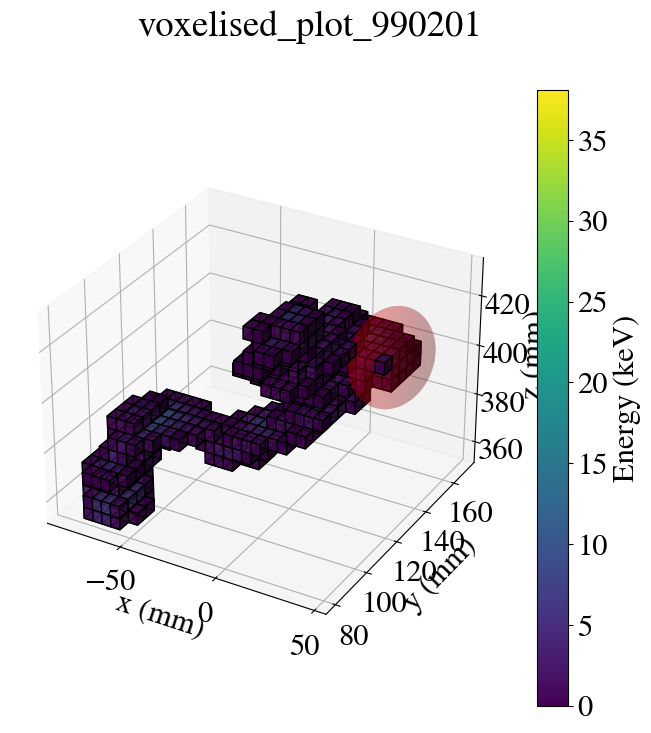

In [40]:
base_vsize = 12 #mm
the_hits = []

xs = x
ys = y
zs = z
es = e

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)
plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + str(evt))

#ax.view_init(-160, 90)

plt.show(fig)



In [41]:


if rotation==True:
    for i in (rotation_space):
        # and plot everything
        fig = plt.figure(figsize=(8,8))
        ax = fig.gca(projection='3d')

        # a, b, c are the corners of the voxels
        ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)
        plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])

        ax.set_xlabel('x (mm)')#,fontsize=16)
        ax.set_ylabel('y (mm)')#,fontsize=16)
        ax.set_zlabel('z (mm)')#,fontsize=16)


        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig.colorbar(sm)
        cb.set_label('Energy (keV)')

        fig.suptitle('voxelised_plot_' + str(evt))
        ax.view_init(20, -i)
        plt.savefig(f'gif_making/voxel/vox_angle_{i}.png')
        plt.close(fig)
        #ax.view_init(-160, 90)


    files = [f for f in os.listdir('gif_making/voxel/') if os.path.isfile(os.path.join('gif_making/voxel/', f))]

    #sort files in a human manner
    files.sort(key=func.alphanum_key)
    images = []
    for filename in files:
        images.append(imageio.imread('gif_making/voxel/' + filename))
    

    print("Creating gif...")
    gif_name = f'output/rotating_voxel_evt_{evt}.gif'
    imageio.mimsave(gif_name, images, loop = 0, fps = 7)

/tmp/ipykernel_12932/1973631466.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995258182)
(-28.561597744166434, -150.45426422894008, -402.3611995

/tmp/ipykernel_12932/1973631466.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('gif_making/voxel/' + filename))


Creating gif...


#### warning, you need to autoset the event number to visualise the new tracks

<img src=output/rotating_voxel_evt_990201.gif width="750" align="center">